# **Connect to GDRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/My Drive/skripsiku/Data/split_data'

test  train  val


# **Import Library**

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import os
from tqdm import tqdm

# **Inisiasi Direktori (Split Data)**

In [5]:
train_dir = '/content/drive/My Drive/skripsiku/Data/split_data/train'
val_dir = '/content/drive/My Drive/skripsiku/Data/split_data/val'
test_dir = '/content/drive/My Drive/skripsiku/Data/split_data/test'

# **Data Preparation**

In [6]:
# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
# Validasi dan test hanya dilakukan rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generator untuk validasi
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 560 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


# **Show Data Augmentasi**

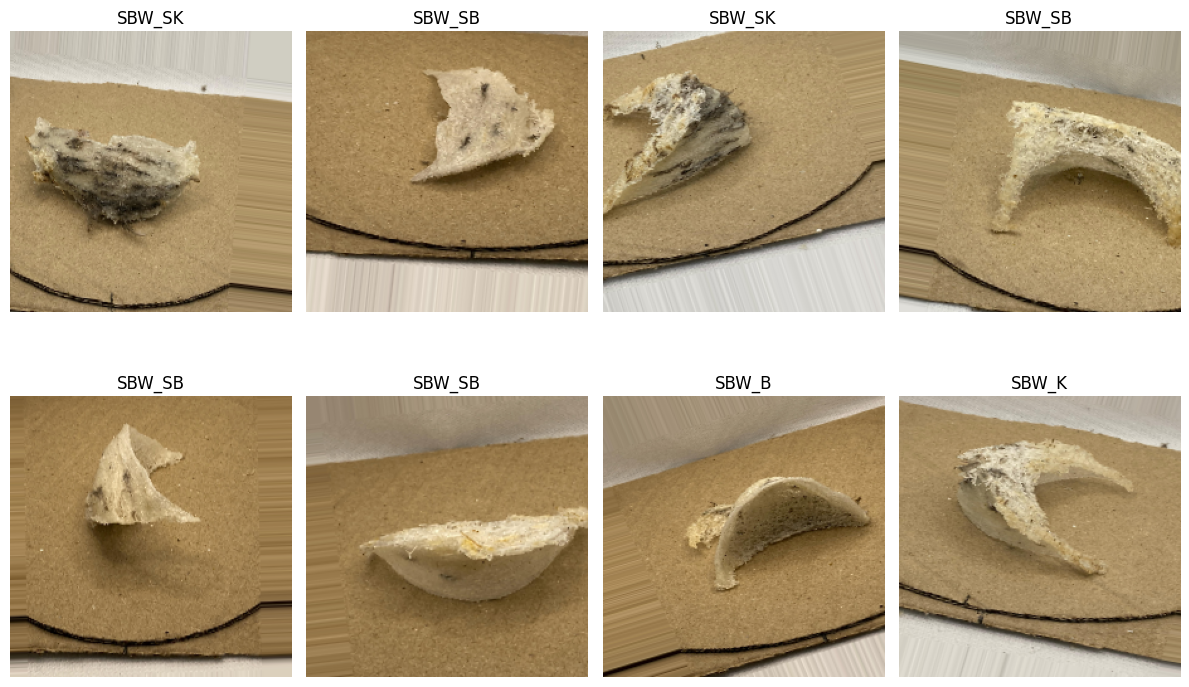

In [15]:
# Ambil satu batch dari train_generator
images, labels = next(train_generator)  # ambil batch pertama

# Ambil mapping kelas dari generator
class_indices = train_generator.class_indices
categories = list(class_indices.keys())  # urutannya sama dengan label output

# Tampilkan 8 gambar pertama
plt.figure(figsize=(12, 8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    plt.title(categories[label_idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
input_dir = '/content/drive/MyDrive/skripsiku/Data/split_data/train'
output_dir = '/content/drive/MyDrive/skripsiku/Data/augmented_data/train'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Proses setiap kelas
for class_name in os.listdir(input_dir):
    class_input_path = os.path.join(input_dir, class_name)
    class_output_path = os.path.join(output_dir, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    if not os.path.isdir(class_input_path):
        continue

    # Proses setiap gambar
    for img_name in tqdm(os.listdir(class_input_path), desc=f'Augmenting {class_name}'):
        img_path = os.path.join(class_input_path, img_name)
        try:
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Simpan 3 versi augmentasi untuk setiap gambar
            i = 0
            for batch in train_datagen.flow(x, batch_size=1, save_to_dir=class_output_path, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= 5:
                    break
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")


Augmenting SBW_B:  31%|███       | 43/140 [16:00<36:25, 22.54s/it]